# Min-Value Entropy Search

*Nicolas Knudde*

In this notebook the Min-Value Entropy Search ([Wang et al., 2017](https://arxiv.org/pdf/1703.01968)) is tested on some benchmark functions and compared to expected improvement.

In [1]:
import numpy as np
import gpflowopt
import gpflow
import matplotlib.pyplot as plt

In [2]:
def branin(x):
    x = np.atleast_2d(x)
    x1 = x[:, 0]
    x2 = x[:, 1]
    a = 1.
    b = 5.1 / (4. * np.pi ** 2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8. * np.pi)
    ret = a * (x2 - b * x1 ** 2 + c * x1 - r) ** 2 + s * (1 - t) * np.cos(x1) + s
    return ret[:, None]

branin_domain = gpflowopt.domain.ContinuousParameter('x1', -5, 10) + \
                gpflowopt.domain.ContinuousParameter('x2', 0, 15)


def shekel(x):
    beta = 1 / 10 * np.array([[1, 2, 2, 4, 4, 6, 3, 7, 5, 5]])
    c = np.expand_dims(np.array([[4, 1, 8, 6, 3, 2, 5, 8, 6, 7],
                                 [4, 1, 8, 6, 7, 9, 3, 1, 2, 3.6],
                                 [4, 1, 8, 6, 3, 2, 5, 8, 6, 7],
                                 [4, 1, 8, 6, 7, 9, 3, 1, 2, 3.6]]), 0)
    f = np.sum(-1 / (np.sum((np.expand_dims(x, -1) - c) ** 2, axis=1) + beta), axis=1)[:, None]
    return f

shekel_domain = gpflowopt.domain.ContinuousParameter('x_0', 0, 10)
for i in range(3):
    shekel_domain += gpflowopt.domain.ContinuousParameter('x_'+str(i+1), 0, 10)

In [3]:
def plot(objective, domain):
    acquisition_opt = gpflowopt.optim.StagedOptimizer([gpflowopt.optim.MCOptimizer(domain, 200),
                                                       gpflowopt.optim.SciPyOptimizer(domain)])

    D = domain.size
    design = gpflowopt.design.LatinHyperCube(int(2.1 ** D), domain)
    X = design.generate()
    Y = objective(X)

    m_mes = gpflow.gpr.GPR(X.copy(), Y.copy(), gpflow.kernels.Matern52(D, ARD=False))
    m_mes.likelihood.variance = 0.001
    m_mes.kern.lengthscales.prior = gpflow.priors.Gamma(5, 1 / 10)
    m_mes.kern.variance.prior = gpflow.priors.Gamma(5, 1 / 10)
    m_mes.likelihood.variance.prior = gpflow.priors.Gamma(5, 1 / 50)
    mes = gpflowopt.acquisition.MinValueEntropySearch(m_mes, domain)
    mes.optimize_restarts = 10

    m_ei = gpflow.gpr.GPR(X.copy(), Y.copy(), gpflow.kernels.Matern52(D, ARD=False))
    m_ei.likelihood.variance = 0.001
    m_ei.kern.lengthscales.prior = gpflow.priors.Gamma(5, 1 / 10)
    m_ei.kern.variance.prior = gpflow.priors.Gamma(5, 1 / 10)
    m_ei.likelihood.variance.prior = gpflow.priors.Gamma(5, 1 / 50)
    ei = gpflowopt.acquisition.ExpectedImprovement(m_ei)
    ei.optimize_restarts = 10

    for a in [mes, ei]:
        optimizer = gpflowopt.BayesianOptimizer(domain, a, optimizer=acquisition_opt)
        with optimizer.silent():
            optimizer.optimize(objective, n_iter=15)
    fig, axes = plt.subplots(1, 1)

    for a, n in zip([mes, ei], ['MES', 'EI']):
        f = a.data[1][:, 0]
        axes.plot(np.arange(0, a.data[0].shape[0]), np.minimum.accumulate(f), label=n)
        axes.set_ylabel('fmin')
        axes.set_xlabel('Number of evaluated points')
        plt.legend()
    plt.show()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


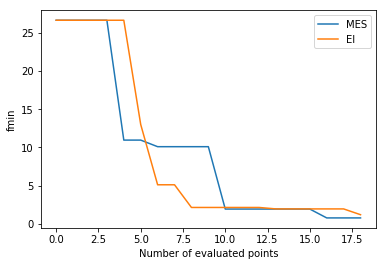

In [4]:
plot(branin, branin_domain)

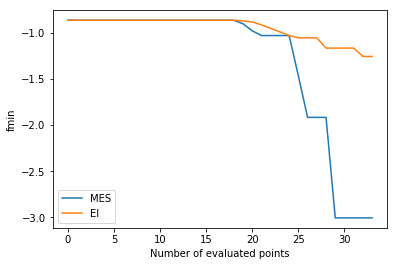

In [5]:
plot(shekel, shekel_domain)